In [597]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm

from tqdm import tqdm
from hurst import compute_Hc
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA
from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler

In [4]:
price_df = pd.read_csv('/Users/yjban/Desktop/MFE/BAF646_Statistical_arbitrage/project/data/us_etf_price.csv')

In [22]:
price_df = price_df.astype({'Date': 'datetime64[ns]'})

In [26]:
price_df['year'] = price_df['Date'].apply(lambda x: x.year)
price_df['month'] = price_df['Date'].apply(lambda x: x.month)

In [534]:
# formation = price_df[(price_df.year == 2022) & ((price_df.month == 1) | (price_df.month == 2) | (price_df.month == 3))]
# formation = formation.set_index('Date')
# formation_etf_list = list(formation[formation.index == '2022-01-03'].tic.unique())

formation = price_df[(price_df.Date>='2010-01-01') & (price_df.Date<'2011-01-01')]
formation = formation.set_index('Date')
formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())

In [535]:
formation

,Open,High,Low,Close,Adj Close,Volume,tic,year,month
Date,,,,,,,,,
2010-01-04,53.470001,53.950001,53.389999,53.860001,40.110847,904100.0,IVE,2010,1
2010-01-05,53.930000,54.180000,53.750000,54.150002,40.326817,682300.0,IVE,2010,1
2010-01-06,54.119999,54.400002,54.070000,54.279999,40.423626,675600.0,IVE,2010,1
2010-01-07,54.270000,54.840000,54.130001,54.750000,40.773643,591800.0,IVE,2010,1
2010-01-08,54.680000,54.860001,54.540001,54.849998,40.848118,351400.0,IVE,2010,1
...,...,...,...,...,...,...,...,...,...
2010-12-27,21.450001,21.540001,21.389999,21.500000,16.015892,101300.0,EWO,2010,12
2010-12-28,21.809999,21.809999,21.549999,21.590000,16.082933,49200.0,EWO,2010,12
2010-12-29,21.830000,22.070000,21.830000,21.990000,16.380911,162600.0,EWO,2010,12


In [536]:
len(formation_etf_list)

456

In [537]:
close_df = pd.DataFrame(index = formation.index.unique())

for x in tqdm(formation_etf_list):
    tmp = test = formation['Close'][formation.tic == x]
    close_df = pd.concat([close_df, tmp], axis=1)

close_df.columns = formation_etf_list

100%|██████████| 456/456 [00:02<00:00, 204.84it/s]


In [538]:
close_df

,IVE,ERTH,SPXS,RYF,QQXT,RFV,FXN,RWJ,FDD,DOG,...,DSI,IGE,PJP,IYW,RBLD,FAZ,TOK,XHB,XLE,EWO
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,53.860001,25.000000,20325.0,16.326817,17.940001,28.750000,17.350000,26.660000,14.49,206.240005,...,21.639999,35.450001,18.900000,14.622500,39.419998,59008.0,37.480000,15.320000,58.810001,20.200001
2010-01-05,54.150002,25.100000,20137.5,16.312849,17.969999,28.889999,17.650000,26.540001,14.47,206.440002,...,21.674999,35.810001,18.780001,14.600000,39.830002,56704.0,37.520000,15.430000,59.290001,20.700001
2010-01-06,54.279999,25.389999,20050.0,16.592178,18.020000,29.280001,18.010000,26.520000,14.50,206.320007,...,21.660000,36.270000,18.760000,14.497500,40.490002,56352.0,37.650002,15.510000,60.000000,20.650000
2010-01-07,54.750000,25.480000,19800.0,16.871508,18.090000,29.490000,17.930000,26.790001,14.45,205.479996,...,21.735001,36.080002,18.790001,14.442500,40.650002,53184.0,37.639999,16.150000,59.910000,20.680000
2010-01-08,54.849998,25.600000,19587.5,16.752792,18.209999,29.700001,18.170000,26.889999,14.45,205.360001,...,21.855000,36.400002,18.809999,14.552500,41.279999,53792.0,37.770000,16.219999,60.299999,20.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,59.520000,26.370001,11012.5,19.532124,21.020000,34.110001,20.830000,32.959999,13.42,177.800003,...,23.495001,40.880001,23.980000,16.145000,43.799999,30048.0,39.889999,17.610001,67.169998,21.500000
2010-12-28,59.639999,26.240000,11000.0,19.504190,21.090000,34.040001,20.879999,32.930000,13.38,177.360001,...,23.514999,41.180000,23.879999,16.147499,44.020000,29984.0,39.860001,17.430000,67.419998,21.590000
2010-12-29,59.650002,26.510000,10950.0,19.511173,21.219999,34.200001,21.129999,32.919998,13.71,177.240005,...,23.504999,41.560001,23.900000,16.165001,44.610001,30144.0,39.980000,17.420000,68.089996,21.990000


In [539]:
rtn_df = close_df.pct_change()[1:]

In [540]:
rtn_df_scaled = pd.DataFrame(StandardScaler().fit_transform(rtn_df))

In [541]:
pca = PCA()
pca.fit(rtn_df_scaled)
cumsum_eigen_value = np.cumsum(pca.explained_variance_ratio_)
pca_components = pca.components_[:np.where(cumsum_eigen_value >= 0.9)[0][0]]

pc_rtn = pd.DataFrame(data=pca_components.T, index=rtn_df.columns)
pc_rtn = pc_rtn.add_prefix("P")
pc_rtn

,P0,P1,P2,P3,P4,P5,P6
IVE,0.050457,-0.010388,-0.015418,0.015423,-0.087908,-0.012974,0.031737
ERTH,0.049624,0.012606,-0.006851,0.029204,0.045184,-0.004910,-0.045389
SPXS,-0.051322,0.014020,0.005324,-0.016109,0.039105,-0.021996,-0.025722
RYF,0.045174,-0.031227,-0.001495,-0.002672,-0.084256,-0.092181,-0.008373
QQXT,0.047966,-0.040450,-0.018374,-0.034328,0.042957,0.020393,0.011326
...,...,...,...,...,...,...,...
FAZ,-0.047209,0.017136,-0.015495,-0.082441,0.140960,0.073630,-0.043544
TOK,0.048614,0.021675,-0.043277,-0.017324,0.004387,-0.001447,-0.048225
XHB,0.044008,-0.047919,0.042542,0.022880,-0.005663,-0.090182,-0.051286
XLE,0.047933,0.024726,0.053231,-0.036753,-0.076237,0.103960,-0.068068


In [542]:
data = StandardScaler().fit_transform(pc_rtn)

In [543]:
clf = DBSCAN(eps=1.8, min_samples=3, n_jobs=1)
clf.fit(data)

labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Clusters discovered: %d" % n_clusters_)

Clusters discovered: 7


In [544]:
pc_rtn

,P0,P1,P2,P3,P4,P5,P6
IVE,0.050457,-0.010388,-0.015418,0.015423,-0.087908,-0.012974,0.031737
ERTH,0.049624,0.012606,-0.006851,0.029204,0.045184,-0.004910,-0.045389
SPXS,-0.051322,0.014020,0.005324,-0.016109,0.039105,-0.021996,-0.025722
RYF,0.045174,-0.031227,-0.001495,-0.002672,-0.084256,-0.092181,-0.008373
QQXT,0.047966,-0.040450,-0.018374,-0.034328,0.042957,0.020393,0.011326
...,...,...,...,...,...,...,...
FAZ,-0.047209,0.017136,-0.015495,-0.082441,0.140960,0.073630,-0.043544
TOK,0.048614,0.021675,-0.043277,-0.017324,0.004387,-0.001447,-0.048225
XHB,0.044008,-0.047919,0.042542,0.022880,-0.005663,-0.090182,-0.051286
XLE,0.047933,0.024726,0.053231,-0.036753,-0.076237,0.103960,-0.068068


In [545]:
clustered = clf.labels_
clustered_series = pd.Series(index = pc_rtn.index, data = clustered.flatten())
clustered_series_all = pd.Series(index = pc_rtn.index, data = clustered.flatten())
clustered_series = clustered_series[clustered_series != 1]

In [546]:
clustered_series

IVE     0
ERTH    0
RYF     0
QQXT    0
RFV     0
       ..
FAZ     6
TOK     0
XHB     0
XLE     0
EWO     0
Length: 440, dtype: int64

In [547]:
cluster_size_limit = 100
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 6
Pairs to evaluate: 88


/Users/yjban/tensorflow/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


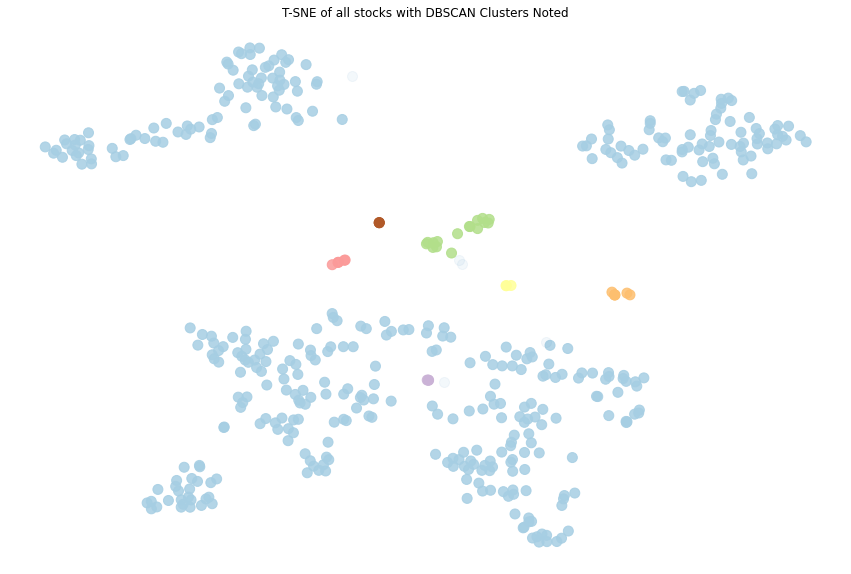

In [548]:
X_tsne = TSNE(learning_rate = 1000, perplexity = 25, random_state = 1337).fit_transform(pc_rtn)

plt.figure(1, facecolor = 'white', figsize = (15, 10))
plt.clf()
plt.axis('off')

plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s = 100, alpha = 0.85, c = labels[labels!=-1], cmap = cm.Paired)
plt.scatter(X_tsne[(clustered_series_all==-1).values, 0], X_tsne[(clustered_series_all==-1).values, 1], s = 100, alpha = 0.05)
plt.title('T-SNE of all stocks with DBSCAN Clusters Noted')
plt.savefig('T-SNE_plot_for_stock_clusters.png')
plt.show()

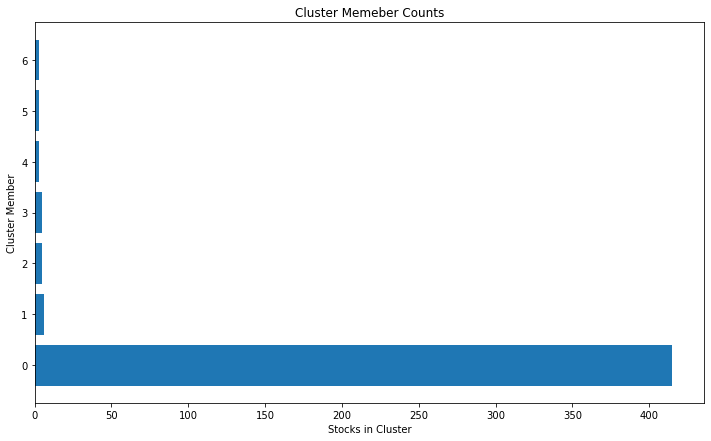

In [549]:
plt.figure(figsize = (12, 7))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Cluster Memeber Counts")
plt.xlabel('Stocks in Cluster')
plt.ylabel("Cluster Member")
plt.savefig('cluster_member_counts.png')
plt.show()

In [550]:
counts = clustered_series.value_counts()
clusters_viz_list = list(counts[(counts < 500) & (counts > 1)].index)[::-1]
print(clusters_viz_list)

[6, 5, 4, -1, 2, 3, 0]


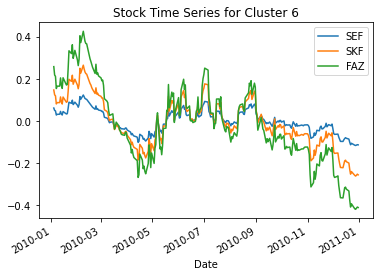

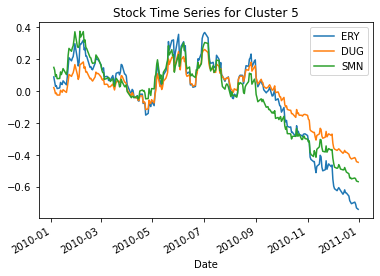

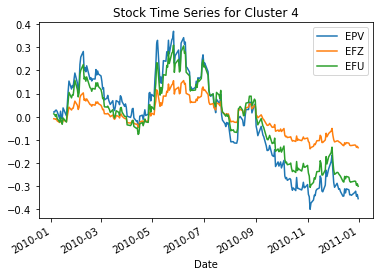

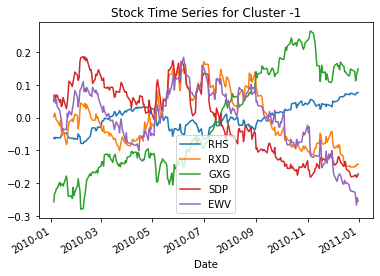

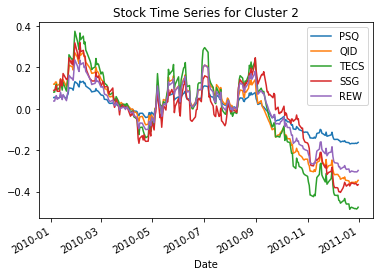

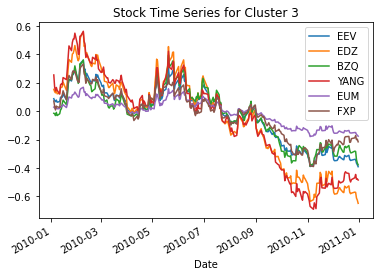

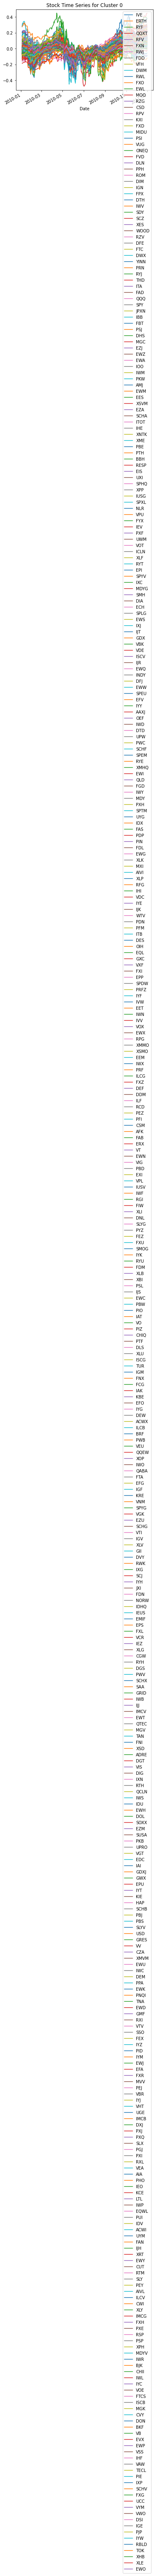

In [551]:
for c in clusters_viz_list:
    stocks = list(clustered_series[clustered_series==c].index)
    means = np.log(close_df.T.loc[stocks,].T.mean())
    data = np.log(close_df.T.loc[stocks,]).T.sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % c)
    plt.savefig('stock_price_clsuter_'+str(c)+'.png')
    plt.show()

In [658]:
rtn_df.corr()

,IVE,ERTH,SPXS,RYF,QQXT,RFV,FXN,RWJ,FDD,DOG,...,DSI,IGE,PJP,IYW,RBLD,FAZ,TOK,XHB,XLE,EWO
IVE,1.000000,0.910488,-0.986679,0.888808,0.891164,0.933698,0.884449,0.898539,0.553625,-0.967327,...,0.946157,0.894657,0.806655,0.888692,0.862837,-0.955030,0.908641,0.831740,0.905127,0.834388
ERTH,0.910488,1.000000,-0.933022,0.813875,0.881176,0.911985,0.866292,0.900225,0.621283,-0.921679,...,0.913511,0.872428,0.755784,0.882845,0.903650,-0.846835,0.905447,0.807670,0.869439,0.882047
SPXS,-0.986679,-0.933022,1.000000,-0.874737,-0.916971,-0.948906,-0.906419,-0.923641,-0.571742,0.977041,...,-0.964735,-0.914386,-0.812860,-0.932000,-0.878070,0.932410,-0.921811,-0.842176,-0.923565,-0.843561
RYF,0.888808,0.813875,-0.874737,1.000000,0.812801,0.864279,0.795277,0.826030,0.491703,-0.842282,...,0.847567,0.790823,0.729465,0.781335,0.792246,-0.889705,0.831467,0.768631,0.805013,0.717255
QQXT,0.891164,0.881176,-0.916971,0.812801,1.000000,0.908829,0.824190,0.886442,0.506075,-0.888219,...,0.899776,0.827193,0.817139,0.859623,0.834492,-0.810066,0.856671,0.799636,0.830241,0.757695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAZ,-0.955030,-0.846835,0.932410,-0.889705,-0.810066,-0.886013,-0.825131,-0.853664,-0.507537,0.902589,...,-0.885206,-0.827438,-0.728205,-0.828501,-0.790664,1.000000,-0.839215,-0.799670,-0.831166,-0.781482
TOK,0.908641,0.905447,-0.921811,0.831467,0.856671,0.876666,0.843296,0.838138,0.610941,-0.912705,...,0.905141,0.869285,0.743699,0.847878,0.868456,-0.839215,1.000000,0.754826,0.873793,0.846473
XHB,0.831740,0.807670,-0.842176,0.768631,0.799636,0.861041,0.766297,0.863983,0.447633,-0.807120,...,0.832072,0.760998,0.662794,0.756773,0.750458,-0.799670,0.754826,1.000000,0.762995,0.689553
XLE,0.905127,0.869439,-0.923565,0.805013,0.830241,0.874912,0.970190,0.832291,0.551907,-0.894928,...,0.870234,0.975201,0.710936,0.818311,0.853955,-0.831166,0.873793,0.762995,1.000000,0.799140


# Pair selection

In [651]:
etf_info = pd.read_csv('/Users/yjban/Desktop/MFE/BAF646_Statistical_arbitrage/project/data/etf_list/etfs_details_equity.csv')
etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')
low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

In [675]:
def Pair_selection(clusters_viz_list, inverse_threshold, coint_pvalue_threshold, hurst_threshold, half_life_threshold, mean_reverting_freq):
    
    selected_pair = []
    for i in tqdm(range(len(clusters_viz_list))):
        test_list = list(clustered_series[clustered_series == clusters_viz_list[i]].index)

        # 1. 거래량 10분위 이하 제거
        vol_screened_test_list = []
        for x in test_list:
            if (x in low_volume_etf) == False:
                vol_screened_test_list.append(x)       
                
        # 2. corr -0.99 보다 작은 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부
        short_avail_test_list = []
        for x in vol_screened_test_list:
            if rtn_df.corr()[x].min() < inverse_threshold:
                short_avail_test_list.append(x)
                
        # 3. Cointegration - pvalue 0.05 이하인 pair sorting
        log_price_data = np.log(close_df[short_avail_test_list])
        comb = list(combinations(short_avail_test_list, 2))
        eg_pvalue = {}

        for x in tqdm(comb):
            score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
            eg_pvalue[x] = pvalue

        possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= coint_pvalue_threshold]

        # 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정
        spread_df = pd.DataFrame(index = log_price_data.index)

        for x in possible_pair:
            spread_df[x] = close_df[x[0]] - close_df[x[1]]
        
        hurst_screened_list = []

        for cnd in possible_pair:
            if compute_Hc(spread_df[cnd])[0] <= hurst_threshold:
                hurst_screened_list.append(cnd)

        spread_df = spread_df[hurst_screened_list]

        # 5. Half life가 trading period 안에 들어오는 종목 스크리닝
        spread_df_lag = spread_df.shift(1)
        spread_df_diff = spread_df - spread_df_lag

        hl_screened_list = []
        for i in range(len(hurst_screened_list)):
            X = sm.add_constant(spread_df_lag.iloc[1:,i])
            model = sm.OLS(spread_df_diff.iloc[1:,i], X)
            result = model.fit()
            lamda = result.params[1]
            HL = -np.log(2) / lamda

        # trading period 고려
            if (HL <= half_life_threshold) & (HL >= 1):
                hl_screened_list.append(hurst_screened_list[i])

        spread_df = spread_df[hl_screened_list]

        # 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝
        freq_screened_list = []

        for j in range(len(spread_df.columns)):

            cnt = 0

            for i in range(len(spread_df.index)):

                if i == len(spread_df.index) -1:
                    break

                elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
                    if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                        cnt += 1

                else:
                    if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                        cnt += 1
            
            if cnt >= mean_reverting_freq:
                freq_screened_list.append(hl_screened_list[j])

        selected_pair.append(freq_screened_list)

    return selected_pair

In [ ]:
Pair_selection(clusters_viz_list=clusters_viz_list, inverse_threshold=0.1, coint_pvalue_threshold=0.05, hurst_threshold=0.5, half_life_threshold=30, mean_reverting_freq=12)

# -----------------------------------------------------------------

# 이하 Pair_selection 작동 로직 풀어서 보여주기

In [552]:
test_list = list(clustered_series[clustered_series == clusters_viz_list[0]].index)
test_list

['SEF', 'SKF', 'FAZ']

## 1. 거래량이 충분한 종목인지 - 10분위 이하는 제거

In [553]:
etf_info = pd.read_csv('/Users/yjban/Desktop/MFE/BAF646_Statistical_arbitrage/project/data/etf_list/etfs_details_equity.csv')

In [554]:
etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')

In [555]:
low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

In [556]:
vol_screened_test_list = []
for x in test_list:
    if (x in low_volume_etf) == False:
        vol_screened_test_list.append(x)        

In [557]:
vol_screened_test_list

['SEF', 'SKF', 'FAZ']

## 2. corr -0.99 이상인 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부

In [558]:
etf_info[etf_info.Symbol.apply(lambda x : x in test_list )]

,Symbol,ETF Name,Asset Class,Total Assets,YTD Price Change,Avg. Daily Volume,Previous Closing Price,1-Day Change,Inverse,Leveraged,...,Volatility Rating,Dividend Rating,Concentration Rating,ESG Score,ESG Score Peer Percentile (%),ESG Score Global Percentile (%),Carbon Intensity (Tons of CO2e / $M Sales),SRI Exclusion Criteria (%),Sustainable Impact Solutions (%),volume
821,FAZ,Direxion Daily Financial Bear 3X Shares,Equity,"$193,456,000",-4.77%,"3,835,680",$18.15,1.51%,Yes,-3x,...,B,A,B,5.67,18.64%,30.27%,1.5,0.00%,0.00%,3835680.0
1354,SEF,ProShares Short Financials,Equity,"$33,894,100",9.27%,"98,253",$12.73,0.63%,Yes,-1x,...,A-,B,A-,0.00,NaN,NaN,NaN,NaN,NaN,98253.0
1577,SKF,ProShares UltraShort Financials,Equity,"$16,655,100",13.54%,"63,388",$18.78,1.40%,Yes,-2x,...,A-,B-,B-,0.00,NaN,NaN,NaN,NaN,NaN,63388.0


In [559]:
short_avail_test_list = []
for x in vol_screened_test_list:
    print(rtn_df.corr()[x].idxmin(), rtn_df.corr()[x].min())

    if rtn_df.corr()[x].min() < -0.99:
        short_avail_test_list.append(x)
        
short_avail_test_list

UYG -0.9982213566272626
UYG -0.9988644649314099
FAS -0.9994180633078865


['SEF', 'SKF', 'FAZ']

## 3. Cointegration - pvalue 0.05 이하인 pair sorting

In [644]:
log_price_data = np.log(close_df[short_avail_test_list])
comb = list(combinations(short_avail_test_list, 2))
eg_pvalue = {}

for x in comb:
    score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
    eg_pvalue[x] = pvalue

print(eg_pvalue)
print('------------------------------------------------')
print('best pair: ', min(eg_pvalue, key=eg_pvalue.get))

{('SEF', 'SKF'): 0.7733920785648577, ('SEF', 'FAZ'): 0.6377026867361617, ('SKF', 'FAZ'): 0.5578237045095392}
------------------------------------------------
best pair:  ('SKF', 'FAZ')


In [648]:
possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= 0.05]

In [649]:
possible_pair

[]

## 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정

In [632]:
spread_df = pd.DataFrame(index = log_price_data.index)

for x in possible_pair:
    spread_df[x] = close_df[x[0]] - close_df[x[1]]

In [633]:
hurst_screened_list = []

for cnd in possible_pair:
    if compute_Hc(spread_df[cnd])[0] <= 0.5:
        hurst_screened_list.append(cnd)

In [634]:
hurst_screened_list

[('SKF', 'FAZ'), ('SEF', 'FAZ'), ('SEF', 'SKF')]

In [635]:
spread_df = spread_df[hurst_screened_list]

## 5. Half life가 trading period 안에 들어오는 종목 스크리닝

In [636]:
spread_df_lag = spread_df.shift(1)
spread_df_diff = spread_df - spread_df_lag

hl_screened_list = []
for i in range(len(hurst_screened_list)):
    X = sm.add_constant(spread_df_lag.iloc[1:,i])
    model = sm.OLS(spread_df_diff.iloc[1:,i], X)
    result = model.fit()
    lamda = result.params[1]
    HL = -np.log(2) / lamda

# trading period 고려
    if (HL <= 30) & (HL >= 1):
        hl_screened_list.append(hurst_screened_list[i])

In [637]:
hl_screened_list

[('SKF', 'FAZ'), ('SEF', 'FAZ'), ('SEF', 'SKF')]

In [638]:
spread_df = spread_df[hl_screened_list]

## 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝

In [639]:
freq_screened_list = []

for j in range(len(spread_df.columns)):

    cnt = 0

    for i in range(len(spread_df.index)):

        if i == len(spread_df.index) -1:
            break

        elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
            if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                cnt += 1

        else:
            if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                cnt += 1
    
    if cnt >= 12:
        freq_screened_list.append(hl_screened_list[j])

In [643]:
freq_screened_list

[('SKF', 'FAZ'), ('SEF', 'FAZ'), ('SEF', 'SKF')]